In [2]:
print("Installing yfinance and getting the data...")
!pip install yfinance 1>/dev/null
!pip install arch 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from statsmodels.base.model import GenericLikelihoodModel
from datetime import datetime

zero,one,two,five,hundred=0e0,1e0,2e0,5e0,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two
SPX=download('^GSPC','1957-03-01').dropna()
SPX['Return']=SPX['Adj Close'].pct_change()*hundred
SPX.index=pd.DatetimeIndex(SPX.index).to_period('D')
SPX.dropna(inplace=True)
#SPX.loc[SPX["Volume"]==0,"Volume"]=np.nan
SPX


Installing yfinance and getting the data...
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Return
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,,
1957-03-04,44.060001,44.060001,44.060001,44.060001,44.060001,1890000,0.731595
1957-03-05,44.220001,44.220001,44.220001,44.220001,44.220001,1860000,0.363141
1957-03-06,44.230000,44.230000,44.230000,44.230000,44.230000,1840000,0.022610
1957-03-07,44.209999,44.209999,44.209999,44.209999,44.209999,1830000,-0.045219
1957-03-08,44.070000,44.070000,44.070000,44.070000,44.070000,1630000,-0.316669
...,...,...,...,...,...,...,...
2024-12-31,5881.629883,5881.629883,5929.740234,5868.859863,5919.740234,3128350000,-0.428480
2025-01-02,5868.549805,5868.549805,5935.089844,5829.529785,5903.259766,3621680000,-0.222389


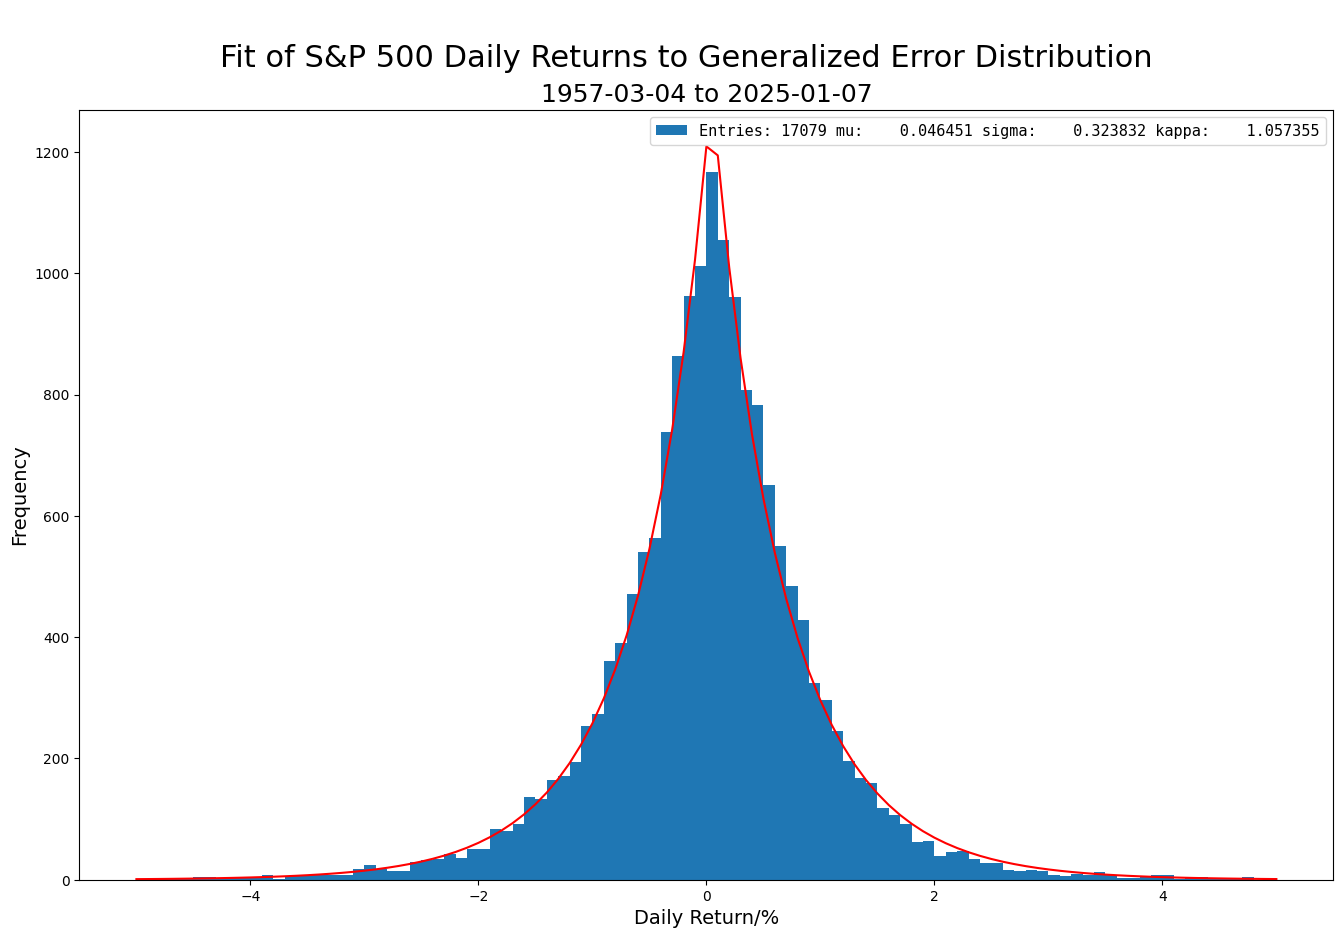

In [3]:
from scipy.stats import gennorm # gennorm is parameterized in such a manner that kappa=1/beta and sigma=scale/(2^kappa)
estimates=gennorm.fit(SPX['Return'])
model=gennorm(*estimates)
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
samples,bins,patches=plot.hist(SPX['Return'],bins=np.linspace(-5,5,101),label="""Entries: %d mu:%12.6f sigma:%12.6f kappa:%12.6f""" % (SPX["Return"].count(),estimates[-2],estimates[-1]/np.power(two,estimates[0]),one/estimates[0]))
plot.plot(bins,model.pdf(bins)*sum(samples)*(bins[-1]-bins[0])/len(bins),'-r')
plot.set_xlabel("Daily Return/%",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
figure.suptitle("\nFit of S&P 500 Daily Returns to Generalized Error Distribution",fontsize=22)
plot.set_title("%s to %s" % (SPX.index[0],SPX.index[-1]),fontsize=18)
pl.setp(plot.legend(loc='upper right',fontsize=11).texts,family='monospace');

In [4]:
mu=estimates[-2]
sigma=estimates[-1]/np.power(two,estimates[0])
kappa=one/estimates[0]

In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gennorm

# Funzione di log-verosimiglianza della GARCH(1,1) con Generalized Error Distribution (GED)
def log_likelihood_garch(params, returns):
    omega, alpha, beta = params[:3]
    nu = params[3]
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(returns)  # Valore iniziale della varianza
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    log_likelihood = np.sum(np.log(gennorm.pdf(returns / np.sqrt(sigma2), nu)) - 0.5 * np.log(sigma2))
    return -log_likelihood  # Minimizzare la funzione negativa della log-verosimiglianza

# Funzione per stimare il modello GARCH(1,1) con GED
def fit_garch_ged_with_given_params(returns, dist_params):
    initial_params = [0.1, 0.1, 0.8, 1.5]  # Parametri iniziali [omega, alpha, beta, nu]
    bounds = [(1e-4, None), (1e-4, 1), (1e-4, 1), (1e-4, None)]
    result = minimize(log_likelihood_garch, initial_params, args=(returns,), bounds=bounds, method='L-BFGS-B')
    return result.x
returns=SPX['Return']
# Utilizziamo i parametri stimati per la distribuzione dei rendimenti
mu = estimates[-2]
sigma = estimates[-1] / np.power(2, estimates[0])
kappa = 1 / estimates[0]
dist_params = (kappa, mu, sigma)

# Stima dei parametri del modello GARCH(1,1) con GED utilizzando i parametri della distribuzione dati
garch_params = fit_garch_ged_with_given_params(returns, dist_params)
print("Estimated GARCH Parameters:", garch_params)


<ipython-input-6-1bc0acb5293b>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]


Estimated GARCH Parameters: [0.00942063 0.09799246 0.90780094 1.37008745]


In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gennorm

# Funzione di log-verosimiglianza della GARCH(1,1) con Generalized Error Distribution (GED)
def log_likelihood_garch(params, returns):
    omega, alpha, beta = params[:3]
    nu = params[3]
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(returns)  # Valore iniziale della varianza
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    log_likelihood = np.sum(np.log(gennorm.pdf(returns / np.sqrt(sigma2), nu)) - 0.5 * np.log(sigma2))
    return -log_likelihood  # Minimizzare la funzione negativa della log-verosimiglianza

# Funzione per stimare il modello GARCH(1,1) con GED
def fit_garch_ged(returns):
    initial_params = [0.1, 0.1, 0.8, 1.5]  # Parametri iniziali [omega, alpha, beta, nu]
    bounds = [(1e-6, None), (1e-6, 1), (1e-6, 1), (1e-6, None)]
    result = minimize(log_likelihood_garch, initial_params, args=(returns,), bounds=bounds, method='L-BFGS-B')
    return result.x

# Utilizziamo i rendimenti per stimare il modello GARCH(1,1) con GED
garch_params = fit_garch_ged(returns)

# Calcolo della volatilità condizionale dei rendimenti
cond_volatility = np.sqrt(garch_params[0] + garch_params[1] * returns[-1]**2 + garch_params[2] * np.var(returns))

# Modernizzazione dei rendimenti dividendo per la volatilità condizionale
modernized_returns = returns / cond_volatility

# Stampiamo i parametri stimati del modello GARCH(1,1) con GED
print("Estimated GARCH Parameters:", garch_params)


<ipython-input-7-3f86fcb58632>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]


Estimated GARCH Parameters: [0.0094212  0.09799432 0.90780045 1.37009631]


<ipython-input-7-3f86fcb58632>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cond_volatility = np.sqrt(garch_params[0] + garch_params[1] * returns[-1]**2 + garch_params[2] * np.var(returns))


<ipython-input-8-2601253bfa93>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_prev = garch_params[0] + garch_params[1] * returns[t-1]**2 + garch_params[2] * (np.var(returns[:t]) if t > 0 else np.var(returns))
<ipython-input-8-2601253bfa93>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_returns[t] = predicted_return


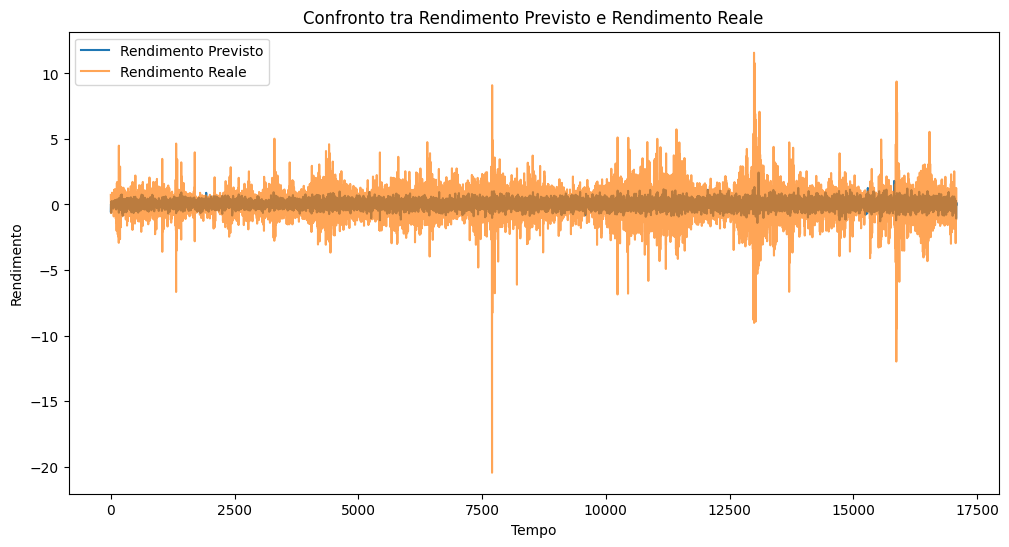

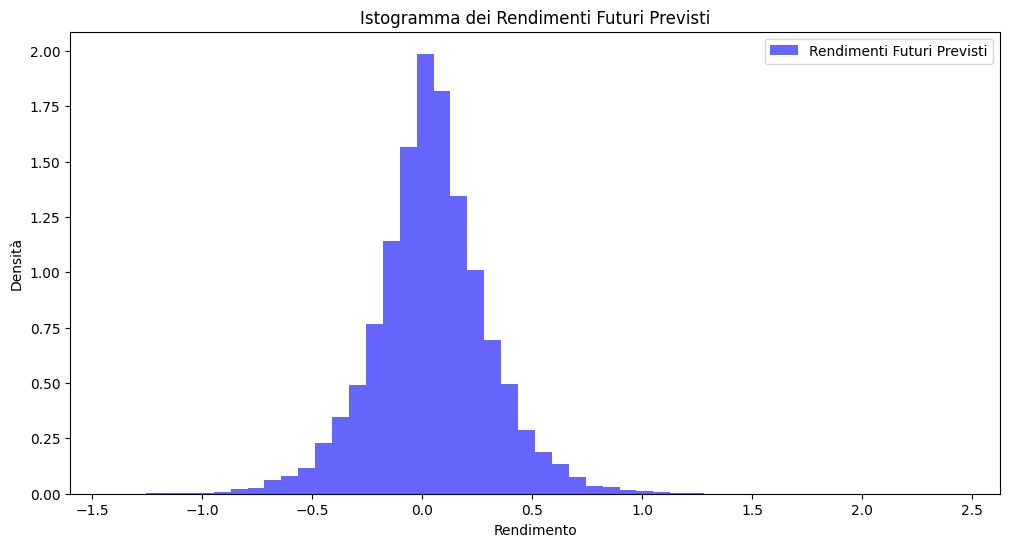

In [8]:
# Previsione dei rendimenti successivi con il modello GARCH(1,1) con GED
import matplotlib.pyplot as plt
predicted_returns = np.zeros_like(returns)
for t in range(len(returns)):
    sigma2_prev = garch_params[0] + garch_params[1] * returns[t-1]**2 + garch_params[2] * (np.var(returns[:t]) if t > 0 else np.var(returns))
    predicted_volatility = np.sqrt(sigma2_prev)
    predicted_return = gennorm.rvs(garch_params[3], loc=mu, scale=sigma, size=1) * predicted_volatility
    predicted_returns[t] = predicted_return

# Plot dei rendimenti previsti e reali
plt.figure(figsize=(12, 6))
plt.plot(predicted_returns, label='Rendimento Previsto')
plt.plot(returns.values, label='Rendimento Reale', alpha=0.7)
plt.title('Confronto tra Rendimento Previsto e Rendimento Reale')
plt.xlabel('Tempo')
plt.ylabel('Rendimento')
plt.legend()
plt.show()
# Plot dell'istogramma dei rendimenti futuri previsti
plt.figure(figsize=(12, 6))
plt.hist(predicted_returns, bins=50, density=True, alpha=0.6, color='b', label='Rendimenti Futuri Previsti')

plt.title('Istogramma dei Rendimenti Futuri Previsti')
plt.xlabel('Rendimento')
plt.ylabel('Densità')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-9-fc0755b3492a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'costante'] = 1


Price      Adj Close     Close      High       Low      Open    Volume
Ticker         ^GSPC     ^GSPC     ^GSPC     ^GSPC     ^GSPC     ^GSPC
Date                                                                  
2019-01-03 -0.024757 -0.024757 -0.010459 -0.009528  0.006040  0.033663
2019-01-04  0.034336  0.034336  0.018022  0.012427 -0.007059  0.097260
2019-01-07  0.007010  0.007010  0.011067  0.020300  0.024766 -0.023858
2019-01-08  0.009695  0.009695  0.005323  0.009110  0.012817 -0.003160
2019-01-09  0.004098  0.004098  0.006008  0.008373  0.004630 -0.007602
...              ...       ...       ...       ...       ...       ...
2021-12-27  0.013839  0.013839  0.010705  0.006384  0.006384 -0.049004
2021-12-28 -0.001010 -0.001010  0.003241  0.009727  0.012991 -0.022514
2021-12-29  0.001402  0.001402 -0.000616 -0.000410 -0.001428  0.094312
2021-12-30 -0.002990 -0.002990  0.001014 -0.000576  0.001167  0.054547
2021-12-31 -0.002626 -0.002626 -0.004596 -0.002006 -0.003967 -0.143084

[756 

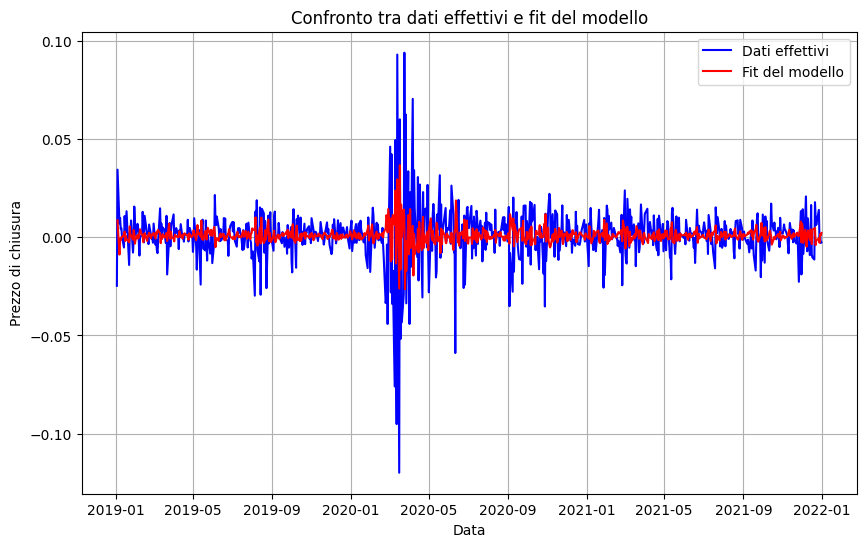

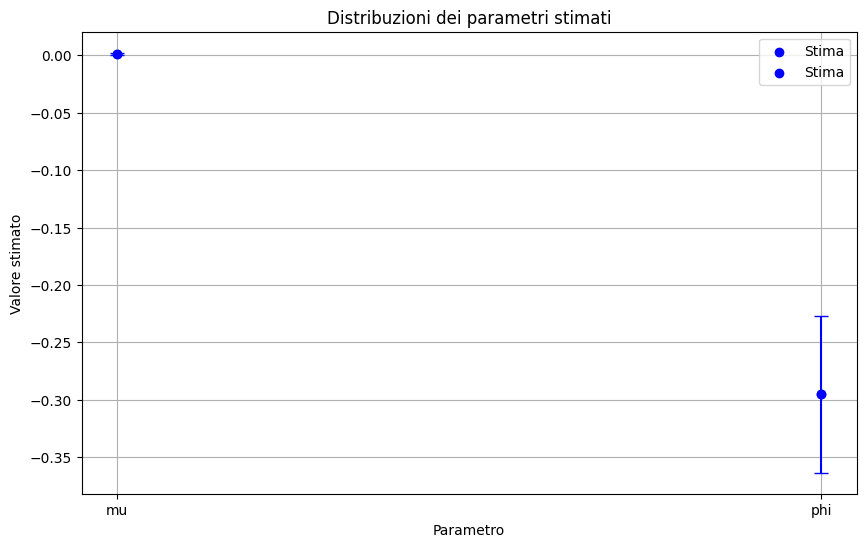

(756,)
(756,)
Date
2019-01-03   -1
2019-01-04    1
2019-01-07   -1
2019-01-08   -1
2019-01-09   -1
             ..
2021-12-27   -1
2021-12-28   -1
2021-12-29    1
2021-12-30    1
2021-12-31    1
Name: Segnale, Length: 756, dtype: int64


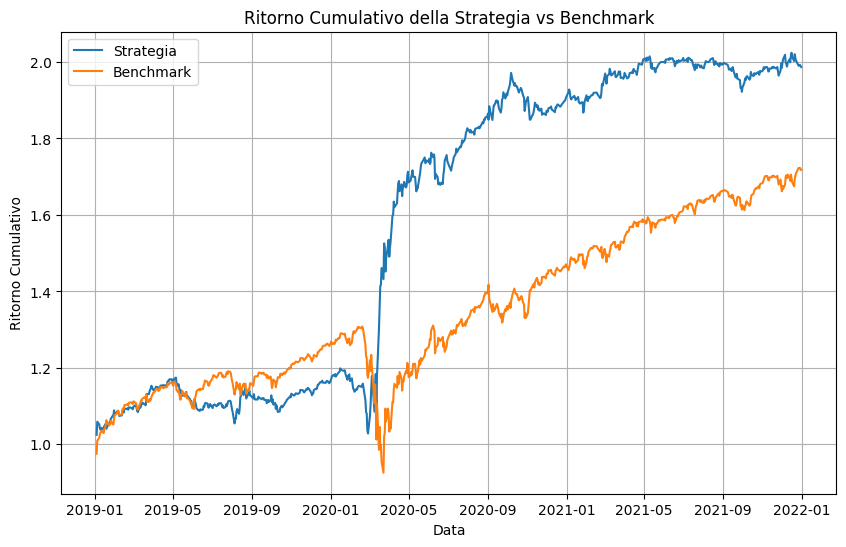

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Scarica i dati da Yahoo Finance
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date).pct_change().dropna()
    return data

# Analizza i dati per stimare mu e phi
def estimate_parameters(data):
    # Calcoliamo r(t-1)
    data['r_t_minus_1'] = data['Close'].shift(1)

    # Rimuoviamo le righe con valori mancanti
    data = data.dropna()

    # Aggiungiamo una costante per la regressione
    data.loc[:, 'costante'] = 1

    # Definiamo le variabili indipendenti (X) e dipendenti (Y)
    X = data[['r_t_minus_1', 'costante']]
    Y = data['Close']  # Usiamo 'Close' come valore da prevedere, potrebbe essere cambiato

    # Costruiamo il modello di regressione lineare
    model = sm.OLS(Y, X).fit()

    # Eseguiamo la regressione per ottenere i parametri stimati
    mu, phi = model.params['costante'], model.params['r_t_minus_1']

    # Calcoliamo gli intervalli di confidenza e il p-value
    conf_int = model.conf_int()
    p_value = model.pvalues['r_t_minus_1']

    return mu, phi, conf_int, p_value

# Definiamo il ticker per l'indice S&P 500 e l'intervallo di tempo desiderato
ticker = "^GSPC"  # ^GSPC è il ticker per l'indice S&P 500 su Yahoo Finance
start_date = "2019-01-01"
end_date = "2022-01-01"

# Scarica i dati
data = download_data(ticker, start_date, end_date)
print(data)
# Stima i parametri mu e phi e calcola gli intervalli di confidenza e il p-value
mu, phi, conf_int, p_value = estimate_parameters(data)

# Stampiamo i risultati
print("Stima dei parametri:")
print("mu:", mu)
print("phi:", phi)
print("\nIntervalli di confidenza:")
print(conf_int)
print("\nP-value:", p_value)
import matplotlib.pyplot as plt

# Dati dei parametri stimati e degli intervalli di confidenza
params = {'mu': mu, 'phi': phi}
conf_intervals = {'mu': conf_int.loc['costante'], 'phi': conf_int.loc['r_t_minus_1']}
import matplotlib.pyplot as plt

# Plot dei dati effettivi
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Dati effettivi', color='blue')

# Plot del fit del modello
predicted_values = mu + phi * data['r_t_minus_1']
plt.plot(data.index, predicted_values, label='Fit del modello', color='red')

# Aggiunta di titoli e etichette
plt.title('Confronto tra dati effettivi e fit del modello')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura')
plt.legend()
plt.grid(True)

# Mostra il grafico
plt.show()
# Plot delle distribuzioni dei parametri stimati
plt.figure(figsize=(10, 6))
for param in params:
    plt.scatter(param, params[param], color='blue', label='Stima')
    plt.errorbar(param, params[param], yerr=[[params[param] - conf_intervals[param][0]], [conf_intervals[param][1] - params[param]]], fmt='o', color='blue', capsize=5)

plt.xlabel('Parametro')
plt.ylabel('Valore stimato')
plt.title('Distribuzioni dei parametri stimati')
plt.legend()
plt.grid(True)
plt.show()
data['alpha'] = mu + phi * data['r_t_minus_1']
# Definiamo la strategia in base a alpha
data['Segnale'] = np.where(data['alpha'] > 0, 1, -1)
# Calcoliamo i ritorni cumulativi della strategia e del benchmark
print(data['Segnale'].shape)
print(data['Close'].values.flatten().shape)
data['Ritorno_Strategia'] = data['Segnale'].values * data['Close'].values.flatten()
print(data['Segnale'])
data['Ritorno_Cumulativo_Strategia'] = 1+(data['Ritorno_Strategia']).cumsum()
data['Ritorno_Cumulativo_Benchmark'] = 1+( data['Close']).cumsum()

# Plot dei ritorni cumulativi
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Ritorno_Cumulativo_Strategia'], label='Strategia')
plt.plot(data.index, data['Ritorno_Cumulativo_Benchmark'], label='Benchmark')
plt.xlabel('Data')
plt.ylabel('Ritorno Cumulativo')
plt.title('Ritorno Cumulativo della Strategia vs Benchmark')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


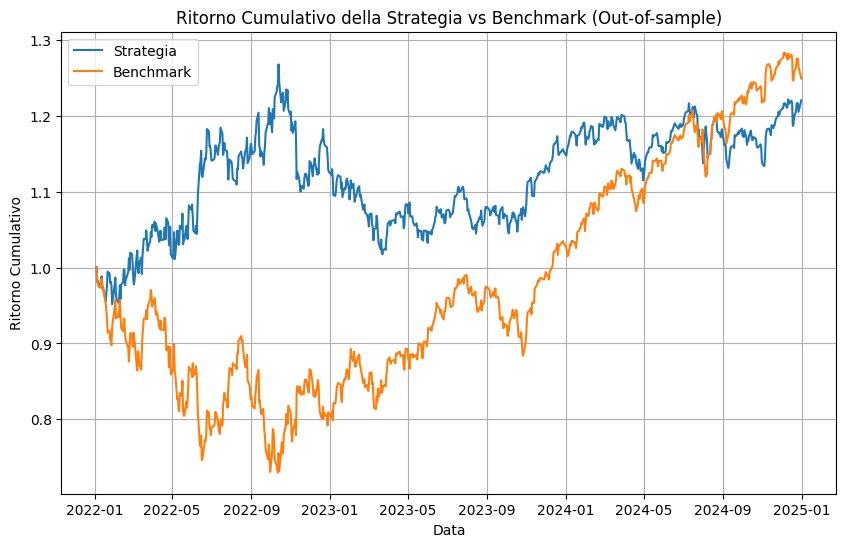

In [10]:
# Definiamo un nuovo intervallo di tempo per i dati out-of-sample
start_date_oos = "2022-01-02"
end_date_oos = "2025-01-01"

# Scarichiamo i dati out-of-sample
data_oos = download_data(ticker, start_date_oos, end_date_oos)
data_oos['r_t_minus_1']=data_oos['Close'].shift(1)
# Utilizziamo i parametri mu e phi ottenuti in precedenza
mu_oos = mu
phi_oos = phi

# Calcoliamo alpha per i dati out-of-sample
data_oos['alpha'] = mu_oos - phi_oos * data_oos['r_t_minus_1']

# Definiamo la strategia in base ad alpha per i dati out-of-sample
data_oos['Segnale'] = np.where(data_oos['alpha'] > 0, 1, -1)

# Calcoliamo i ritorni cumulativi della strategia e del benchmark per i dati out-of-sample
data_oos['Ritorno_Strategia'] = data_oos['Segnale'].values.flatten() * data_oos['Close'].values.flatten()
data_oos['Ritorno_Cumulativo_Strategia'] = 1+( data_oos['Ritorno_Strategia']).cumsum()
data_oos['Ritorno_Cumulativo_Benchmark'] = 1+( data_oos['Close']).cumsum()

# Plot dei ritorni cumulativi per i dati out-of-sample
plt.figure(figsize=(10, 6))
plt.plot(data_oos.index, data_oos['Ritorno_Cumulativo_Strategia'], label='Strategia')
plt.plot(data_oos.index, data_oos['Ritorno_Cumulativo_Benchmark'], label='Benchmark')
plt.xlabel('Data')
plt.ylabel('Ritorno Cumulativo')
plt.title('Ritorno Cumulativo della Strategia vs Benchmark (Out-of-sample)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Funzione di densità della Generalized Error Distribution (GED)
def ged_pdf(x, nu):
    beta = (2**(-1/nu) * gamma(1/nu) / gamma(3/nu))**0.5
    return np.exp(-0.5 * np.abs(x / beta)**nu) / (beta * gamma(1 + 1/nu) * 2**(1 + 1/nu))

# Funzione di log-verosimiglianza della GED
def log_likelihood_ged(params, returns):
    omega, alpha, beta, nu = params
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(returns)  # Valore iniziale della varianza
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]

    # Calcolo della log-verosimiglianza
    log_likelihood = np.sum(np.log(ged_pdf(returns / np.sqrt(sigma2), nu)) - 0.5 * np.log(sigma2))
    return -log_likelihood  # Minimizzare la funzione negativa della log-verosimiglianza

# Funzione per stimare il modello GARCH(1,1) con GED
def fit_garch_ged(returns):
    initial_params = [0.1, 0.1, 0.8, 1.5]  # Parametri iniziali [omega, alpha, beta, nu]
    bounds = [(1e-6, None), (1e-6, 1), (1e-6, 1), (1e-6, None)]
    result = minimize(log_likelihood_ged, initial_params, args=(returns,), bounds=bounds, method='L-BFGS-B')
    return result.x

# Funzione per calcolare la volatilità condizionale con i parametri stimati
def calculate_conditional_volatility(params, returns):
    omega, alpha, beta, _ = params
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(returns)  # Valore iniziale della varianza
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    return np.sqrt(sigma2)
# Funzione per generare campioni da una GED
def sample_ged(nu, size=1):
    beta = (2**(-1/nu) * gamma(1/nu) / gamma(3/nu))**0.5
    u = np.random.uniform(0, 1, size)
    sign = np.where(u < 0.5, -1, 1)
    return sign * (np.log(2 * np.where(sign > 0, u, 1 - u)) / beta**nu)**(1/nu)

# Funzione per prevedere i rendimenti a uno step
def predict_one_step(params, returns):
    omega, alpha, beta, nu = params
    sigma2_prev = omega + alpha * returns[-1]**2 + beta * (np.var(returns) if len(returns) == 1 else calculate_conditional_volatility(params, returns)[-1]**2)
    predicted_volatility = np.sqrt(sigma2_prev)
    predicted_return = sample_ged(nu) * predicted_volatility
    return predicted_return

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model

import numpy as np
from scipy.optimize import minimize
from scipy.special import gamma
ticker = "^GSPC"  # ^GSPC è il ticker per l'indice S&P 500 su Yahoo Finance
start_date = "2019-01-01"
end_date = "2022-01-01"

# Scarica i dati
data = download_data(ticker, start_date, end_date)

returns = data['Close'].dropna().values#*100
print(returns)
params = fit_garch_ged(returns)
print("Estimated Parameters: ", params)

# Calcolo della volatilità condizionale
conditional_volatility = calculate_conditional_volatility(params, returns)

# Grafici diagnostici
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Residuals plot
plt.subplot(2, 1, 1)
plt.plot(returns, label='Returns')
plt.title('Returns')
plt.legend()

# Conditional volatility plot
plt.subplot(2, 1, 2)
plt.plot(conditional_volatility, label='Conditional Volatility', color='red')
plt.title('Conditional Volatility')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gamma, gammaln
import matplotlib.pyplot as plt

# Funzione di densità della Generalized Error Distribution (GED)
def ged_pdf(x, nu):
    beta = (2**(-1/nu) * gamma(1/nu) / gamma(3/nu))**0.5
    return np.exp(-0.5 * np.abs(x / beta)**nu) / (beta * gamma(1 + 1/nu) * 2**(1 + 1/nu))

# Funzione di log-verosimiglianza della GED
def log_likelihood_ged(params, returns):
    omega, alpha, beta, nu = params
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(returns)  # Valore iniziale della varianza
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]

    # Calcolo della log-verosimiglianza
    log_likelihood = np.sum(np.log(ged_pdf(returns / np.sqrt(sigma2), nu)) - 0.5 * np.log(sigma2))
    return -log_likelihood  # Minimizzare la funzione negativa della log-verosimiglianza

# Funzione per stimare il modello GARCH(1,1) con GED
def fit_garch_ged(returns):
    initial_params = [0.1, 0.1, 0.8, 1.5]  # Parametri iniziali [omega, alpha, beta, nu]
    bounds = [(1e-6, None), (1e-6, 1), (1e-6, 1), (1e-6, None)]
    result = minimize(log_likelihood_ged, initial_params, args=(returns,), bounds=bounds, method='L-BFGS-B')
    return result.x

# Funzione per calcolare la volatilità condizionale con i parametri stimati
def calculate_conditional_volatility(params, returns):
    omega, alpha, beta, _ = params
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(returns)  # Valore iniziale della varianza
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    return np.sqrt(sigma2)

def sample_ged(nu, size=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    beta = (2**(-1/nu) * gamma(1/nu) / gamma(3/nu))**0.5
    u = np.random.uniform(0, 1, size)
    sign = np.where(u < 0.5, -1, 1)
    return sign * (np.log(2 * np.where(sign > 0, u, 1 - u)) / beta**nu)**(1/nu)

# Funzione per prevedere i rendimenti a uno step
def predict_one_step(params, returns, seed=None):
    omega, alpha, beta, nu = params
    sigma2_prev = omega + alpha * returns[-1]**2 + beta * (np.var(returns) if len(returns) == 1 else calculate_conditional_volatility(params, returns)[-1]**2)
    predicted_volatility = np.sqrt(sigma2_prev)
    predicted_return = sample_ged(nu, seed=seed) * predicted_volatility
    return predicted_return

data = download_data(ticker, start_date, end_date)

returns = data['Close'].dropna().values*100
# Stima dei parametri del modello GARCH(1,1) con GED
params = fit_garch_ged(returns)
print("Estimated Parameters: ", params)

# Previsione a uno step dei rendimenti e applicazione della strategia
predicted_returns = np.zeros_like(returns)+1
seed = 42
for t in range(len(returns)):
    predicted_returns[t] = predict_one_step(params, returns[:t+1], seed=seed)
    seed += 1  # Cambia il seed per ogni previsione per evitare ripetizioni

# Strategia Buy and Hold
buy_and_hold_returns = returns

# Strategia basata sul modello GARCH (previsioni a uno step)
garch_strategy_returns = predicted_returns

# Calcolo dei rendimenti cumulativi per entrambe le strategie
buy_and_hold_cumulative = np.cumsum(buy_and_hold_returns)
garch_strategy_cumulative = np.cumsum(garch_strategy_returns)

# Grafici delle performance cumulative delle due strategie
plt.figure(figsize=(12, 6))

# Buy and Hold plot
plt.plot(buy_and_hold_cumulative, label='Buy and Hold Strategy', color='blue')

# GARCH Strategy plot
plt.plot(garch_strategy_cumulative, label='GARCH Strategy', color='red')

plt.title('Cumulative Returns: Buy and Hold vs GARCH Strategy')
plt.legend()
plt.show()


In [ ]:
from scipy.stats import gennorm

# Distribuzione dei rendimenti reali
plt.figure(figsize=(12, 6))
plt.hist(returns, bins=50, density=True, alpha=0.6, color='b', label='Rendimenti Reali')

# Calcolo della distribuzione teorica utilizzando i parametri stimati per la GED
dist_params = (params[3], 0, np.sqrt(params[0] / (1 - params[1] - params[2])))
x = np.linspace(min(predicted_returns), max(predicted_returns), 100)
pdf_fitted = gennorm.pdf(x, *dist_params)

# Sovrapposizione della distribuzione teorica
plt.plot(x, pdf_fitted, 'r-', label='Fit Distribuzione Teorica')

plt.title('Distribuzione dei Rendimenti Reali e Fit Distribuzione Teorica')
plt.xlabel('Rendimento')
plt.ylabel('Densità')
plt.legend()
plt.show()

